<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/env-soundnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# B2: Environmental Sound Classification

*The goal of this project is to explore innovative approaches to achieve state-of-the-art performance in environmental sound classification using advanced machine learning techniques.*


## Setup

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydub librosa

In [4]:
# Loading necessary libraries
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn
import shutil
import os
import pydub # Library used to handle audio files
import librosa

In [ ]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)

Moved 1-100032-A-0.wav to /content/drive/MyDrive/HumanData/ESC-50/dog/1-100032-A-0.wav
Moved 1-100032-A-0.wav to /content/drive/MyDrive/HumanData/ESC-10/dog/1-100032-A-0.wav
Moved 1-100038-A-14.wav to /content/drive/MyDrive/HumanData/ESC-50/chirping_birds/1-100038-A-14.wav
Moved 1-100210-A-36.wav to /content/drive/MyDrive/HumanData/ESC-50/vacuum_cleaner/1-100210-A-36.wav
Moved 1-100210-B-36.wav to /content/drive/MyDrive/HumanData/ESC-50/vacuum_cleaner/1-100210-B-36.wav
Moved 1-101296-A-19.wav to /content/drive/MyDrive/HumanData/ESC-50/thunderstorm/1-101296-A-19.wav
Moved 1-101296-B-19.wav to /content/drive/MyDrive/HumanData/ESC-50/thunderstorm/1-101296-B-19.wav
Moved 1-101336-A-30.wav to /content/drive/MyDrive/HumanData/ESC-50/door_wood_knock/1-101336-A-30.wav
Moved 1-101404-A-34.wav to /content/drive/MyDrive/HumanData/ESC-50/can_opening/1-101404-A-34.wav
Moved 1-103298-A-9.wav to /content/drive/MyDrive/HumanData/ESC-50/crow/1-103298-A-9.wav
Moved 1-103995-A-30.wav to /content/drive/My

,0
0,None
1,None
2,None
3,None
4,None
...,...
1995,None
1996,None
1997,None
1998,None


In [ ]:
%ls /content/drive/MyDrive/HumanData/ESC-50/

airplane/        clock_alarm/       door_wood_knock/   insects/          siren/
breathing/       clock_tick/        drinking_sipping/  keyboard_typing/  sneezing/
brushing_teeth/  coughing/          engine/            laughing/         snoring/
can_opening/     cow/               fireworks/         mouse_click/      thunderstorm/
car_horn/        crackling_fire/    footsteps/         pig/              toilet_flush/
cat/             crickets/          frog/              pouring_water/    train/
chainsaw/        crow/              glass_breaking/    rain/             vacuum_cleaner/
chirping_birds/  crying_baby/       hand_saw/          rooster/          washing_machine/
church_bells/    dog/               helicopter/        sea_waves/        water_drops/
clapping/        door_wood_creaks/  hen/               sheep/            wind/


## Exploratory Analysis

The ESC dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short environmental recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, Ogg Vorbis compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through the Freesound.org project. Please see the README files for a detailed attribution list.

The dataset consists of three parts:

1. ESC-50: a labeled set of 2 000 environmental recordings (50 classes, 40 clips per class),

2. ESC-10: a labeled set of 400 environmental recordings (10 classes, 40 clips per class) (this is a subset of ESC-50 - created initialy as a proof-of-concept/standardized selection of easy recordings),

3. ESC-US: an unlabeled dataset of 250 000 environmental recordings (5-second-long clips), suitable for unsupervised pre-training.

The ESC-US dataset, although not hand-annotated, includes the labels (tags) submitted by the original uploading users, which could be potentially used in weakly-supervised learning experiments (noisy and/or missing labels). The ESC-10 and ESC-50 datasets have been prearranged into 5 uniformly sized folds, making sure that clips extracted from the same original source recording are always contained in a single fold.


In [21]:
class Clip:
  """A single 5-sec long recording."""

  SAMPLING_RATE = 44100

  class Audio:
    """ The actual audio data of the clip.

        Uses a context manager to load/unload the raw audio data. This way clips
        can be processed sequentially with reasonable memory usage.
    """

    def __init__(self, path) -> None:
      self.path = path

    # returns the resource that needs to be managed
    def __enter__(self):
      # silent AudioSegment  used to trim/overlay frame inacurate clips
      self.data = pydub.AudioSegment.silent(duration=5000)
      self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
      self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)
      return (self)

   # does not return anything but performs the cleanup operations
    def __exit__(self, exception_type, exception_value, traceback):
      if exception_type is not None:
        print (exception_type)
        print(exception_value)
        print(traceback)
      del self.data
      del self.raw

  def __init__(self, filename) -> None:
    self.filename = os.path.basename(filename)
    self.path = os.path.abspath(filename)
    self.directory = os.path.dirname(self.path)
    self.category = self.directory.split('/')[-1]

    self.audio = Clip.Audio(self.path)

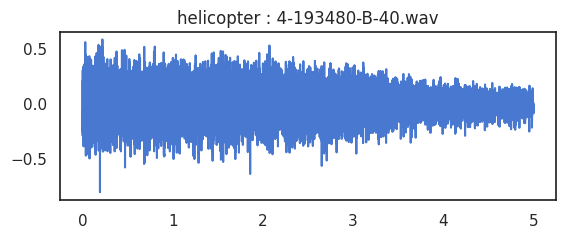

In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

import random
import IPython.display
import glob

wav_files = glob.glob('/content/drive/MyDrive/HumanData/ESC-50/*/*.wav')
clip = Clip(random.choice(wav_files))

with clip.audio as audio:
   plt.subplot(2, 1, 1)
   plt.title('{0} : {1}'.format(clip.category, clip.filename))
   plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)

IPython.display.Audio(filename=clip.path, rate=Clip.SAMPLING_RATE)